In [249]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [191]:
import sklearn
import itertools
import tensorflow as tf

In [5]:
import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

In [333]:
import time
import sys
import pymongo
import os
sys.path.append('../scripts/')

import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import pandas as pd
from functools import reduce
import seaborn as sns
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

In [7]:
# mergeResults,segmentsMeta, mergedSegments= osmMerger.mergeSegments(minValidData = osmMerger.MIN_VALID_DATA, weights=osmMerger.WEIGHTS,speedsMx=speeds)
# mergeResults.to_pickle("../data/mergeResults.pckl")
# segmentsMeta.to_pickle("../data/segmentsMeta.pckl")

In [8]:
mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")

In [9]:
from importlib import reload

In [10]:
from models import *

In [11]:
speeds = pd.read_pickle("../data/monthsSpeed.pckl")
counts = pd.read_pickle('../data/monthsCount.pckl')
data_cleaner = DataCleaner(speeds,segmentsMeta,mergeResults,counts)

In [12]:
speedDF = data_cleaner.data
countDF = data_cleaner.counts

In [13]:
adjacency_matrix = OsmProcessing.getAdjacencyMatrix(segmentsMeta)
adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,1)
adjacency_matrix=OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults,segmentsMeta)
adjacency_matrix=adjacency_matrix[speedDF.index].loc[speedDF.index]

In [ ]:
def createMlpModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):

    model = tf.keras.models.Sequential()
    #layers
    model.add(tf.keras.layers.Flatten())
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.Dense(neuronsPerLayer*(i+1)))
    model.add(tf.keras.layers.Dense(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

def createStackedLstmModel(loss,optimizer,nlayers,neuronsPerLayer,relu_output):
    model = tf.keras.models.Sequential()
    #layers
    for i in range(nlayers)  :    
        model.add(tf.keras.layers.LSTM(neuronsPerLayer*(i+1),return_sequences=True))
    model.add(tf.keras.layers.LSTM(nSegments,name='out_layer'))
    if relu_output :
        model.add(tf.keras.layers.ReLU())
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
build_grid= {'optimizer':['Adam'],
              'nlayers':[0,1,3],
              'neuronsPerLayer':[64],
              'loss':['MSE','MAE'],
              'relu_output':[False]
             }

train_grid={
    "batch_size":[8,32,64], 
    "epochs":[100], 
    "validation_split":[0.5]
}

preprocess_grid={
    'scale_Max':[True],
    'scale_log':[False],
    'input_lag':[1,6],
    'output_lag':[1],
    'time_as_input':[True],
    "validation_split":[0.5]

}

def getParamsFromGrid(grid):
    return [dict(list(zip(list(grid.keys()),x ))) for x in list(itertools.product(*list(grid.values())))]

def grid_search(data,buildfunc,build_grid,train_grid,preprocess_grid):

    grid = list(itertools.product( getParamsFromGrid(build_grid),
                                   getParamsFromGrid(train_grid),
                                   getParamsFromGrid(preprocess_grid)
                                 )
               )
    
    losses=[]
    val_losses=[]
    mseLoss=[]
    mseValLoss=[]
    for build_param,train_param,preprocess_param in grid :
        print(build_param,train_param,preprocess_param)
        x,y = preprocessData(data,**preprocess_param)
        xtrain = x[:int(len(x)*(train_param['validation_split']))]
        xtest = x[int(len(x)*(train_param['validation_split'])):]
        ytrain = y.reshape(-1,nSegments)[:int(len(x)*(train_param['validation_split']))]
        ytest = y.reshape(-1,nSegments)[int(len(x)*(train_param['validation_split'])):]
        tf.keras.backend.clear_session()
        tf.keras.backend.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

        model=buildfunc(**build_param)
        model.fit(xtrain,ytrain.reshape(-1,nSegments),validation_data = (xtest,ytest), **train_param,verbose=0)
        
        losses.append(model.evaluate(xtrain,ytrain,verbose=0))
        val_losses.append(model.evaluate(xtest,ytest,verbose=0))
        
        mseLoss.append(mse(reversePreProcess(ytrain,**preprocess_param),reversePreProcess(model.predict(xtrain),**preprocess_param)))
        mseValLoss.append(mse(reversePreProcess(ytest,**preprocess_param),reversePreProcess(model.predict(xtest),**preprocess_param)))
        print(losses[-1],val_losses[-1],mseLoss[-1],mseValLoss[-1])
        
    resDF=pd.DataFrame(list(zip(grid,losses,val_losses,mseLoss,mseValLoss)),columns=['params','loss_value','val_loss_value','mseLoss','mseValLoss'])
    
    return  pd.concat([resDF.params.apply(lambda x : pd.Series({**x[0],**x[1],**x[2]})),resDF[['loss_value','val_loss_value','mseLoss','mseValLoss']]],axis=1)


In [ ]:
# resMlpDF = grid_search(data,createMlpModel,build_grid,train_grid,preprocess_grid)

In [ ]:
# resLstmDF.groupby("time_as_input")['mseLoss'].describe()

In [ ]:
# resLstmDF = grid_search(data,createStackedLstmModel,build_grid,train_grid,preprocess_grid)

In [182]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""
def multiInputMultiOutputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:], name="speed_input")
    lstm = tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(nSegments,name="lstm_branch")(lstm)

    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x = tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    
#     x=tf.keras.layers.Dense( nSegments, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer,lstm_branch] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()
    

In [183]:
def monoInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(300,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(300,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )( lstm_branch)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    x=tf.keras.layers.Dense( 300, activation = tf.keras.activations.sigmoid )(x)
    output_layer = tf.keras.layers.Dense( nSegments,name="Output",use_bias=False )(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [184]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(200,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(200,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 200, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    

In [185]:
def multiInputModelLstmWithLastQuarter():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 4, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 50)           159800      speed_input[0][0]                
        __________________________________________________________________________________________________
        last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
        __________________________________________________________________________________________________
        lstm_branch (Dense)             (None, 100)          5100        speed_lstm[0][0]                 
        __________________________________________________________________________________________________
        MLP_branch (Dense)              (None, 100)          74900       last_quarter_speeds[0][0]        
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 202)          0           lstm_branch[0][0]                
                                                                         MLP_branch[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense[0][0]                      
        ==================================================================================================
        Total params: 335,648
        Trainable params: 335,648
        Non-trainable params: 0
        __________________________________________________________________________________________________
    
    """
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(250,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(250,activation= tf.keras.activations.sigmoid,name="MLP_branch")(lambda_slice_layer)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, mlp_breanch, daytime_input])
    
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dense( 250, activation = tf.keras.activations.sigmoid )(x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh  , use_bias=False)(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mae , optimizer=optimizer)   
    

In [186]:
def multiInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(100,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    lambda_slice_layer = tf.keras.layers.Lambda(lambda x : x[:,data_model.input_lag-1,:],name="last_quarter_speeds")(main_input)
    mlp_breanch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="slice_MLP_branch")(lambda_slice_layer)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, mlp_breanch, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [187]:
def monoInputModelMLP():
    """
    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    speed_input (InputLayer)        (None, 4, 748)       0                                            
    __________________________________________________________________________________________________
    flatten_multi_speed (Flatten)   (None, 2992)         0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_speed_mpl (Dense)          (None, 100)          299300      flatten_multi_speed[0][0]        
    __________________________________________________________________________________________________
    last_quarter_speeds (Lambda)    (None, 748)          0           speed_input[0][0]                
    __________________________________________________________________________________________________
    full_mlp_branch (Dense)         (None, 100)          10100       full_speed_mpl[0][0]             
    __________________________________________________________________________________________________
    slice_MLP_branch (Dense)        (None, 100)          74900       last_quarter_speeds[0][0]        
    __________________________________________________________________________________________________
    day_time_input (InputLayer)     (None, 2)            0                                            
    __________________________________________________________________________________________________
    Merge (Concatenate)             (None, 202)          0           full_mlp_branch[0][0]            
                                                                     slice_MLP_branch[0][0]           
                                                                     day_time_input[0][0]             
    __________________________________________________________________________________________________
    dense (Dense)                   (None, 100)          20300       Merge[0][0]                      
    __________________________________________________________________________________________________
    Output (Dense)                  (None, 748)          75548       dense[0][0]                      
    ==================================================================================================
    Total params: 480,148
    Trainable params: 480,148
    Non-trainable params: 0
    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    flatten_layer = tf.keras.layers.Flatten(name="flatten_multi_speed")(main_input)
    mlp=tf.keras.layers.Dense(350,name="full_speed_mpl")(flatten_layer)
    
    mlp = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="full_mlp_branch")(mlp)
    
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([mlp, daytime_input])
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output", activation = tf.keras.activations.tanh , use_bias=False)(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)

In [245]:
"""
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(100,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(100,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm, daytime_input])
    x=tf.keras.layers.Dense( 100, activation = tf.keras.activations.sigmoid )( merge_layer)
    output_layer = tf.keras.layers.Dense(nSegments,name="Output" )(x)
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer] )
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse , optimizer=optimizer)   
    data_model.model.summary()
"""

def multiInputModelLstm():
    """
        __________________________________________________________________________________________________
        Layer (type)                    Output Shape         Param #     Connected to                     
        ==================================================================================================
        speed_input (InputLayer)        (None, 5, 748)       0                                            
        __________________________________________________________________________________________________
        speed_lstm (LSTM)               (None, 100)          339600      speed_input[0][0]                
        __________________________________________________________________________________________________
        day_time_input (InputLayer)     (None, 2)            0                                            
        __________________________________________________________________________________________________
        Merge (Concatenate)             (None, 102)          0           speed_lstm[0][0]                 
                                                                         day_time_input[0][0]             
        __________________________________________________________________________________________________
        dense_15 (Dense)                (None, 100)          10300       Merge[0][0]                      
        __________________________________________________________________________________________________
        Output (Dense)                  (None, 748)          75548       dense_15[0][0]                   
        ==================================================================================================
        Total params: 425,448
        Trainable params: 425,448
        Non-trainable params: 0
        __________________________________________________________________________________________________

    """
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    lstm=tf.keras.layers.LSTM(350,name="speed_lstm")(main_input)
    lstm_branch = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)
    
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( x)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)
    
    
    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()


In [246]:
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67
model_name ="LSTM timed shift mean max scale"

data_model = models.DataModel( speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split, shift_mean = True, scale_max = True )

data_model.preprocessData()

x_train, y_train, x_test, y_test = data_model.trainSplit()

train_days, test_days = data_model.getDaysTypes()

tf.keras.backend.clear_session()

multiInputModelLstm()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 5, 692)       0                                            
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 350)          1460200     speed_input[0][0]                
__________________________________________________________________________________________________
lstm_branch (Dense)             (None, 350)          122850      speed_lstm[0][0]                 
__________________________________________________________________________________________________
day_time_input (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
Merge (Con

In [304]:
def countInputModelLstm():
    main_input = tf.keras.layers.Input( x_train.shape[1:], name="speed_input")

    count_input = tf.keras.layers.Input( count_train.shape[1:], name="count_input")

    count_speed_merge = tf.keras.layers.Concatenate(2,name="count_speed_merge")([main_input, count_input])

    lstm=tf.keras.layers.LSTM(350, name="speed_lstm")(count_speed_merge)
    lstm_branch = tf.keras.layers.Dense(350,activation= tf.keras.activations.sigmoid,name="lstm_branch")(lstm)
    daytime_input = tf.keras.layers.Input(shape=train_days.shape[1:],name="day_time_input")
    merge_layer = tf.keras.layers.Concatenate(1,name="Merge")([lstm_branch, daytime_input])
    x=tf.keras.layers.Dense( 350, activation = tf.keras.activations.sigmoid )( merge_layer)

    output_layer = tf.keras.layers.Dense(nSegments,name="Output")(x)


    data_model.model = tf.keras.Model(inputs = [main_input,daytime_input,count_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss=tf.keras.losses.mse, optimizer=optimizer)
    data_model.model.summary()

In [334]:
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67
model_name = "/unknown"

data_model = models.DataModel( speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split, shift_mean = True, scale_max = True )

data_model.preprocessData()



x_train, y_train, x_test, y_test = data_model.trainSplit()


count_model = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
count_train, _, count_test, _ = data_model.trainSplit()


train_days, test_days = data_model.getDaysTypes()



tf.keras.backend.clear_session()



In [302]:
batch_size = sequence_length - input_lag - output_lag
print(data_model.model.summary())
modelHist = data_model.model.fit([x_train,train_days,count_train],[y_train],validation_data=([x_test,test_days,count_test],y_test),batch_size=batch_size,epochs=40)
print(data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test))
print(data_model.mae(data_model.predict('train'),y_train),data_model.mae(data_model.predict('test'),y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        (None, 5, 692)       0                                            
__________________________________________________________________________________________________
count_input (InputLayer)        (None, 5, 692)       0                                            
__________________________________________________________________________________________________
count_speed_merge (Concatenate) (None, 5, 1384)      0           speed_input[0][0]                
                                                                 count_input[0][0]                
__________________________________________________________________________________________________
speed_lstm (LSTM)               (None, 350)          2429000     count_speed_merge[0][0]          
__________

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 3 array(s), but instead got the following list of 2 arrays: [array([[[-4.45040329e-02, -6.07711014e-02, -9.81967019e-02, ...,
         -1.20597936e-03,  6.16723767e-02,  2.95252873e-02],
        [-5.47604432e-02,  9.76904371e-02, -7.53736124e-03, ...,
        ...

In [365]:
nSegments = len(speedDF)
input_lag, output_lag, sequence_length = 5, 1, 20
valid_split = 0.67
model_name = "AzdzR5/"

data_model = models.DataModel( speedDF, input_lag, output_lag, sequence_length, valid_split = valid_split )

data_model.preprocessData()



x_train, y_train, x_test, y_test = data_model.trainSplit()



model = models.BaseModels('AR5',speedDF[speedDF.columns[:int(len(speedDF)*data_model.valid_split)]])

data_model.model=model
print(data_model.mse(data_model.predict('train'),y_train),data_model.mse(data_model.predict('test'),y_test))
print(data_model.mae(data_model.predict('train'),y_train),data_model.mae(data_model.predict('test'),y_test))

Training the AR(5) model
Train data shape: (692, 463)

Filling the voids...
Filling done. New train data shape: (692, 3651)

Training the models...
Params: max_lag: 5


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !
188.50602930289315 192.82133732007657
10.010084678796112 10.159573698614922


In [366]:
model_plotting = models.ModelPlots(data_model,data_cleaner)

 segment 59


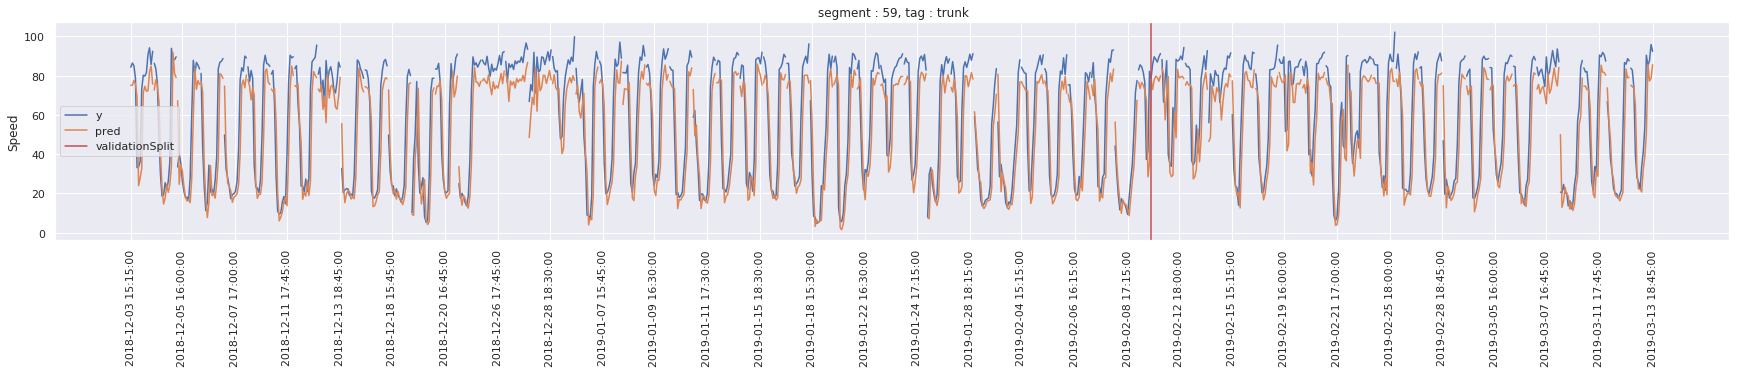

In [367]:
model_plotting.plotSegmentSeries(59)
saveFig()

 all segments


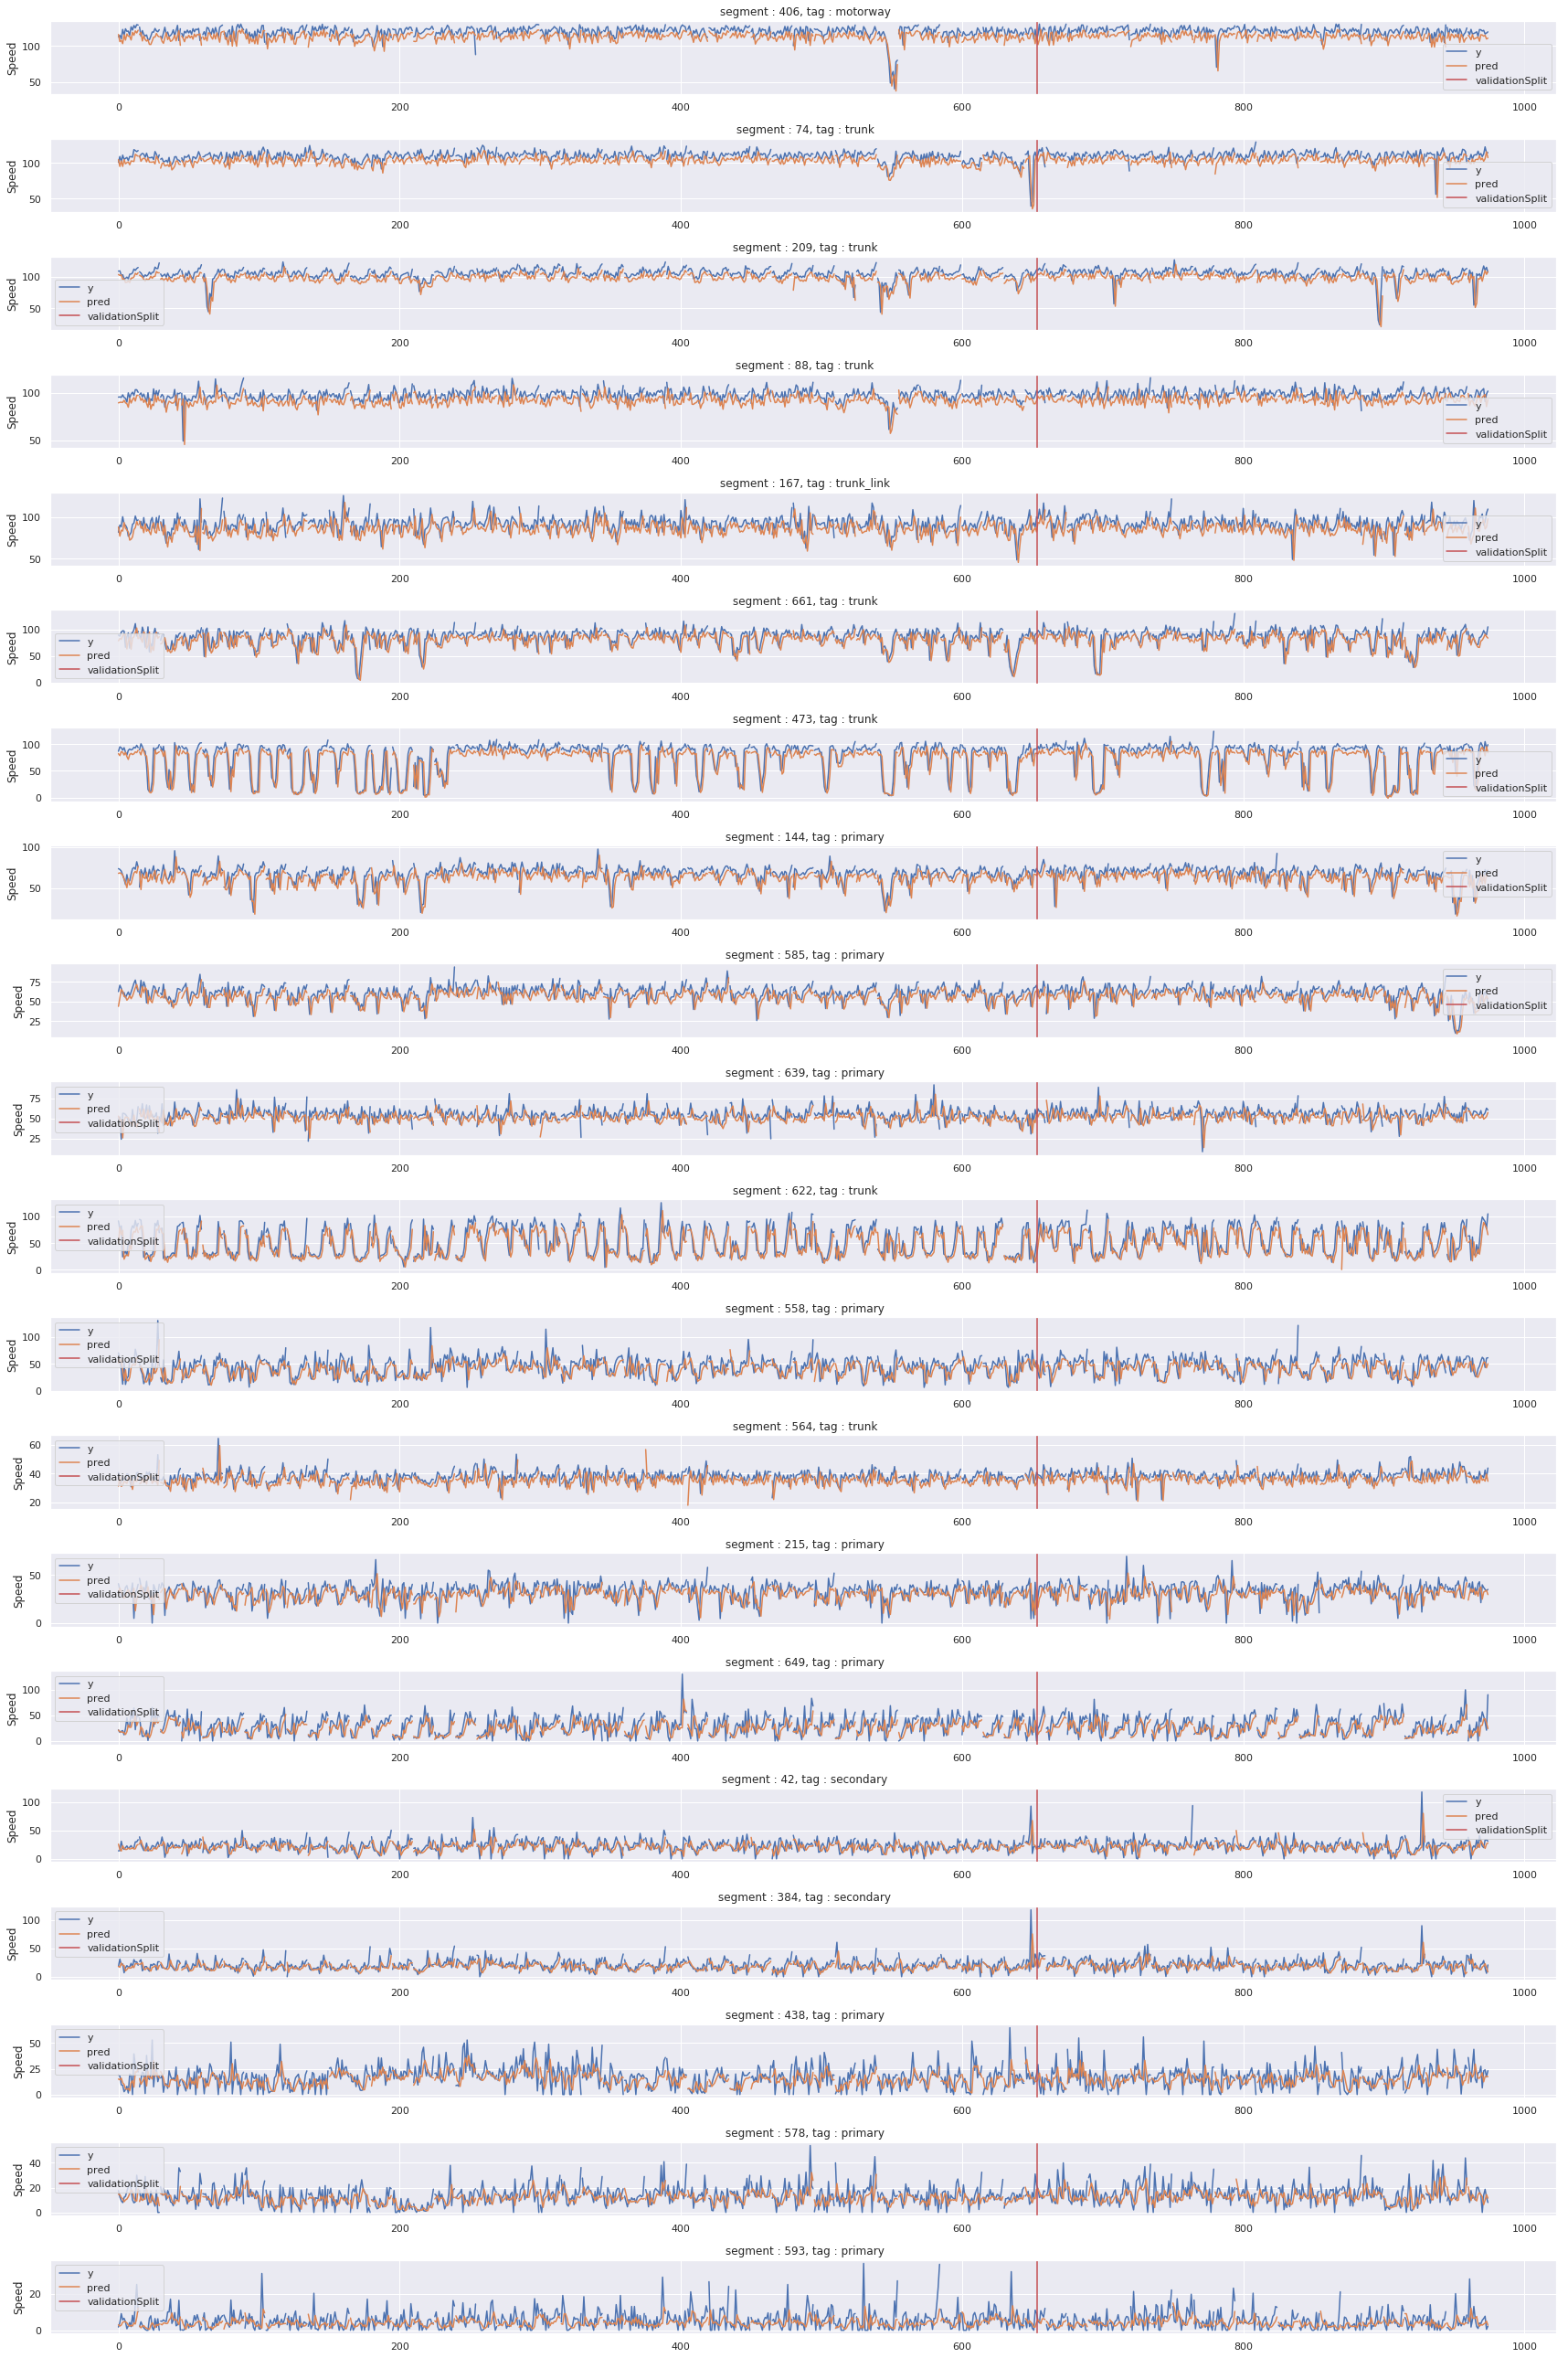

In [368]:
model_plotting.plotMultipleSegmentsSeries()
saveFig()

 density train


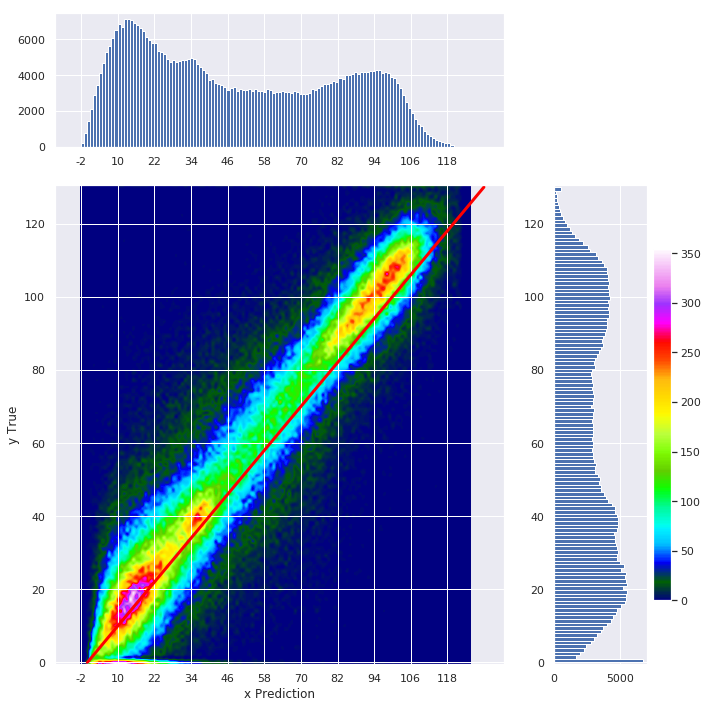

In [369]:
model_plotting.plotPredictionMatchHeatMap("train")
saveFig()

 density valid


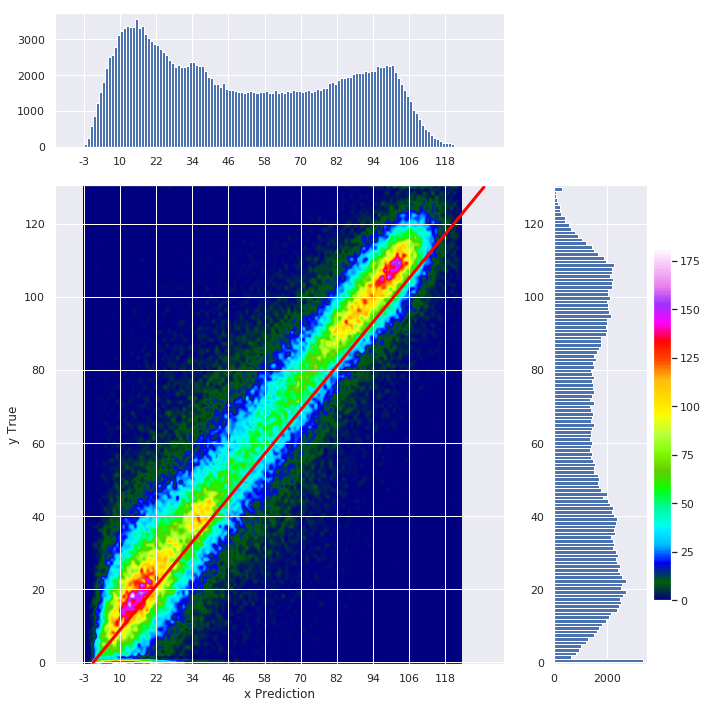

In [370]:
model_plotting.plotPredictionMatchHeatMap("valid")
saveFig()

In [371]:
yDF=data_model.restorePredictionsAsDF(data_model.y)
predDF = data_model.restorePredictionsAsDF( data_model.predict('full'))

# folium_map = plotPredictions(segmentsMeta,data_model, yDF, predDF, yDF.columns[np.r_[:len(yDF.columns)-1:10j].astype(int)],mergedIndex,updatedcounts)
folium_map=folium.plugins.DualMap(location=[48.10301,-1.65537],
                    zoom_start=13,
                    tiles="OpenStreetMap")

folium.features.LinearColormap([plt.cm.brg_r(0),plt.cm.brg_r(0.5)],caption="Error rate").add_to(folium_map.m1)

folium_train_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[8:14:1].astype(int)],folium_map=folium_map.m1)
folium_validation_map = model_plotting.plotPredictions(yDF,predDF,yDF.columns[np.r_[len(yDF.columns)*valid_split+8:len(yDF.columns)*valid_split+14:1].astype(int)],folium_map=folium_map.m2)

folium_map.save(results_path+model_name+input()+' map.html')

 pred


In [343]:
taggedPred = predDF.assign(tag = data_cleaner.segments_tags)
taggedy = yDF.assign(tag = data_cleaner.segments_tags)

In [344]:
taggedy.groupby('tag').mean()

,2018-12-03 15:15:00,2018-12-03 15:30:00,2018-12-03 15:45:00,2018-12-03 16:00:00,2018-12-03 16:15:00,2018-12-03 16:30:00,2018-12-03 16:45:00,2018-12-03 17:00:00,2018-12-03 17:15:00,2018-12-03 17:30:00,...,2019-03-13 16:30:00,2019-03-13 16:45:00,2019-03-13 17:00:00,2019-03-13 17:15:00,2019-03-13 17:30:00,2019-03-13 17:45:00,2019-03-13 18:00:00,2019-03-13 18:15:00,2019-03-13 18:30:00,2019-03-13 18:45:00
tag,,,,,,,,,,,,,,,,,,,,,
motorway,114.885387,115.823042,106.814434,118.252615,108.229856,114.509946,110.899663,113.285720,109.159587,115.432675,...,106.798598,108.851660,111.719730,116.187610,116.766256,119.939878,119.874840,119.571056,119.077945,114.014854
motorway_link,101.196567,100.678741,98.786058,97.370385,99.815600,95.976190,96.198864,98.667974,100.974444,100.252273,...,93.851443,104.143198,104.768464,103.107046,104.063615,105.004535,107.375254,105.101498,101.332428,106.102083
primary,36.458427,33.645428,33.605797,32.202251,30.713870,29.698657,31.990944,31.578286,32.804004,33.942329,...,31.779345,32.762701,34.873904,34.379100,36.779110,37.100850,36.984902,38.402502,39.653124,39.710976
primary_link,57.750000,62.250000,52.571429,44.648593,34.916667,41.666667,43.886864,47.500000,47.820753,47.300000,...,50.187500,49.220198,45.291667,46.525000,62.650000,61.660714,43.791667,24.650000,77.650000,57.000000
secondary,21.284810,22.196531,21.592573,18.638563,19.090106,17.470435,17.405648,17.877130,18.086855,22.915587,...,21.444338,24.247847,21.927456,23.372069,21.648683,23.581000,24.513936,24.902682,27.046307,25.012973
tertiary,27.336303,23.827717,23.572332,24.861386,21.378651,27.244595,20.587460,21.700893,23.990082,25.892311,...,25.550812,23.237352,26.036154,25.044137,27.210221,32.547284,28.974728,27.701570,32.292727,31.154583
trunk,88.066458,89.030301,87.999299,86.247003,82.960489,80.431234,79.992409,83.456594,84.071903,87.046641,...,81.268278,82.592452,84.103530,85.077949,89.069661,90.766724,92.433780,92.629130,93.265997,93.124613
trunk_link,65.891199,65.317593,64.121717,64.348946,57.662146,56.970032,57.915545,56.478129,58.317517,62.308328,...,57.820336,58.873630,64.011679,63.820749,64.705014,64.575990,69.869854,68.803420,68.469752,69.089297


In [345]:
pd.DataFrame((abs(predDF-yDF)).mean(axis=1)).assign(tag = data_cleaner.segments_tags).groupby('tag').describe()

0                                                        \
               count       mean       std        min        25%        50%   
tag                                                                          
motorway        11.0   7.670510  2.296248   4.868368   5.852099   8.028397   
motorway_link   10.0   8.127733  0.997195   6.268824   7.564816   8.215839   
primary        261.0  10.299862  2.601311   4.059682   8.503132   9.948505   
primary_link     2.0  13.186365  3.634765  10.616198  11.901282  13.186365   
secondary       54.0  10.606733  2.078274   6.365758   9.067660  10.279440   
tertiary        25.0  10.925098  2.481591   4.382016   9.945068  11.413881   
trunk          252.0   9.049374  3.425246   3.580980   6.342972   8.338078   
trunk_link      77.0  11.787125  4.393231   5.296134   8.688893  10.658365   

                                     
                     75%        max  
tag                                  
motorway        8.843307  12.743392  
motorway_link   8.969624   9.329810  
primary        12.140950  17.789882  
primary_link   14.471449  15.756533  
secondary      12.014524  16.042595  
tertiary       12.576979  15.003951  
trunk          11.215608  21.620501  
trunk_link     14.754391  23.717291

In [346]:
countDF.groupby(pd.DatetimeIndex(countDF.columns).time,axis=1).mean().assign(tag = data_cleaner.segments_tags).groupby('tag').agg(['mean'])

,14:00:00,14:15:00,14:30:00,14:45:00,15:00:00,15:15:00,15:30:00,15:45:00,16:00:00,16:15:00,16:30:00,16:45:00,17:00:00,17:15:00,17:30:00,17:45:00,18:00:00,18:15:00,18:30:00,18:45:00
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
tag,,,,,,,,,,,,,,,,,,,,
motorway,14.416783,15.079720,15.367832,16.050350,16.555245,17.935664,18.109091,19.730070,18.904895,20.033566,19.902098,21.041958,20.860140,21.448951,20.394406,18.206993,16.054545,14.344056,12.443357,10.634965
motorway_link,5.456923,5.564615,5.955385,5.989231,6.104615,6.432308,6.749231,7.060000,7.086154,7.113846,7.580000,8.001538,7.661538,7.936923,7.466154,6.730769,5.830769,5.143077,4.610769,4.018462
primary,4.943649,4.977365,5.013498,5.116239,5.127498,5.370056,5.509343,6.065841,6.225405,6.500265,6.889007,7.035249,7.094017,6.989920,6.496375,5.970292,5.227233,4.637076,4.045270,3.370645
primary_link,2.300000,2.969231,2.676923,3.446154,3.353846,3.369231,4.000000,3.876923,4.415385,4.946154,4.315385,4.784615,5.053846,4.846154,4.500000,4.115385,3.323077,2.807692,2.546154,2.230769
secondary,6.092308,5.959544,6.051282,6.116809,6.129630,6.290598,6.465527,6.715100,6.767236,7.290028,7.257265,7.747009,7.898860,8.139886,7.580057,7.167236,6.970655,6.724501,5.735897,5.042165
tertiary,6.904000,6.630769,6.597538,6.396308,6.506462,6.774154,7.129231,7.158154,7.544615,8.175385,7.927385,8.163077,8.164923,8.054769,7.037538,6.646154,5.652923,4.941538,4.101538,3.188923
trunk,10.701221,10.990110,11.215873,11.404701,11.559951,12.120452,12.483272,13.205128,13.752076,14.839133,15.764408,16.249634,16.036508,15.963431,15.201099,13.838156,12.213248,10.690965,9.341087,7.656716
trunk_link,3.972827,4.000999,4.065335,4.127273,4.161439,4.438162,4.630569,4.880919,4.945055,5.489710,5.882318,6.075325,5.943656,5.752847,5.434565,4.896304,4.220380,3.672927,3.140859,2.617582


In [347]:
 yDF.assign(tag = data_cleaner.segments_tags).groupby('tag').agg(['mean'])

,2018-12-03 15:15:00,2018-12-03 15:30:00,2018-12-03 15:45:00,2018-12-03 16:00:00,2018-12-03 16:15:00,2018-12-03 16:30:00,2018-12-03 16:45:00,2018-12-03 17:00:00,2018-12-03 17:15:00,2018-12-03 17:30:00,...,2019-03-13 16:30:00,2019-03-13 16:45:00,2019-03-13 17:00:00,2019-03-13 17:15:00,2019-03-13 17:30:00,2019-03-13 17:45:00,2019-03-13 18:00:00,2019-03-13 18:15:00,2019-03-13 18:30:00,2019-03-13 18:45:00
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
tag,,,,,,,,,,,,,,,,,,,,,
motorway,114.885387,115.823042,106.814434,118.252615,108.229856,114.509946,110.899663,113.285720,109.159587,115.432675,...,106.798598,108.851660,111.719730,116.187610,116.766256,119.939878,119.874840,119.571056,119.077945,114.014854
motorway_link,101.196567,100.678741,98.786058,97.370385,99.815600,95.976190,96.198864,98.667974,100.974444,100.252273,...,93.851443,104.143198,104.768464,103.107046,104.063615,105.004535,107.375254,105.101498,101.332428,106.102083
primary,36.458427,33.645428,33.605797,32.202251,30.713870,29.698657,31.990944,31.578286,32.804004,33.942329,...,31.779345,32.762701,34.873904,34.379100,36.779110,37.100850,36.984902,38.402502,39.653124,39.710976
primary_link,57.750000,62.250000,52.571429,44.648593,34.916667,41.666667,43.886864,47.500000,47.820753,47.300000,...,50.187500,49.220198,45.291667,46.525000,62.650000,61.660714,43.791667,24.650000,77.650000,57.000000
secondary,21.284810,22.196531,21.592573,18.638563,19.090106,17.470435,17.405648,17.877130,18.086855,22.915587,...,21.444338,24.247847,21.927456,23.372069,21.648683,23.581000,24.513936,24.902682,27.046307,25.012973
tertiary,27.336303,23.827717,23.572332,24.861386,21.378651,27.244595,20.587460,21.700893,23.990082,25.892311,...,25.550812,23.237352,26.036154,25.044137,27.210221,32.547284,28.974728,27.701570,32.292727,31.154583
trunk,88.066458,89.030301,87.999299,86.247003,82.960489,80.431234,79.992409,83.456594,84.071903,87.046641,...,81.268278,82.592452,84.103530,85.077949,89.069661,90.766724,92.433780,92.629130,93.265997,93.124613
trunk_link,65.891199,65.317593,64.121717,64.348946,57.662146,56.970032,57.915545,56.478129,58.317517,62.308328,...,57.820336,58.873630,64.011679,63.820749,64.705014,64.575990,69.869854,68.803420,68.469752,69.089297
